# Behavioural Cloning Project 3
### Self Driving Car ND Course - Alistair Kirk Mar 29 2017

#### Begin by importing the training data and saving it to an h5 model:

In [ ]:
import csv
import numpy as np
import cv2
from tqdm import tqdm 

lines = []
# CSV Data Structure: center,left,right,steering,throttle,brake,speed
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

correction = 0.2

for line in tqdm(lines):
    #Find the steering angle for this line:
    measurement = float(line[3])

    #Create steering adjustments for different cameras        
    steering_center = measurement
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    steering_correction = [steering_center, steering_left, steering_right]
        
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = 'data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image)                
        measurements.append(steering_correction[i])        

aug_images, aug_measurements = [],[]
for image, measurement in zip(images, measurements):
    aug_images.append(image)
    aug_measurements.append(measurement)
    aug_images.append(cv2.flip(image,1))
    aug_measurements.append(measurement*-1.0)
    
X_train = np.array(aug_images)
y_train = np.array(aug_measurements)

print("X_train, y_train compiled with augmented shapes {}, {}".format(X_train.shape, y_train.shape))

#### Alternatively: Use a Generator Function to handle large datasets

In [1]:
import os
import csv

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print("Using {} Training Samples and {} Validation Samples".format(len(train_samples),
                                                                   len(validation_samples)))

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            # Define camera correction factor for L/R Cams:
            correction = 0.35
            
            # Create images and angles:
            for batch_sample in batch_samples:
                measurement = float(batch_sample[3])
                
                #Create steering adjustments for different cameras        
                steering_center = measurement
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                steering_correction = [steering_center, steering_left, steering_right]
                
                for i in range(3):
                    source_path = batch_sample[i]
                    filename = source_path.split('/')[-1]
                    current_path = 'data/IMG/' + filename
                    image = cv2.imread(current_path)
                    images.append(image)                
                    angles.append(steering_correction[i])
                
                #name = './IMG/'+batch_sample[0].split('/')[-1]
                #center_image = cv2.imread(name)
                #center_angle = float(batch_sample[3])
                #images.append(center_image)
                #angles.append(center_angle)
            aug_images, aug_angles = [],[]
            for image, angle in zip(images, angles):
                aug_images.append(image)
                aug_angles.append(angle)
                aug_images.append(cv2.flip(image,1))
                aug_angles.append(angle*-1.0)
            
            X_train = np.array(aug_images)
            y_train = np.array(aug_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

Using 16388 Training Samples and 4098 Validation Samples


#### Build neural network to train the model then save it

Epoch 1/4
175s - loss: 0.0668 - val_loss: 0.0583
Epoch 2/4
162s - loss: 0.0515 - val_loss: 0.0491
Epoch 3/4
163s - loss: 0.0485 - val_loss: 0.0456
Epoch 4/4
163s - loss: 0.0451 - val_loss: 0.0427
dict_keys(['loss', 'val_loss'])


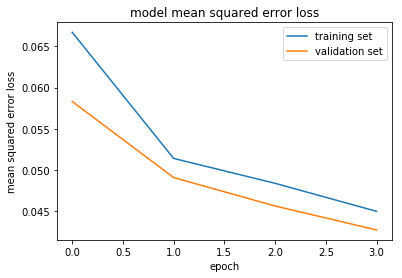

model saved
walltime: 666 seconds
166.5 seconds per epoch


In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

import time

t = time.time()

EPOCHS = 4
b_size = 32
#print("Training: {} images over {} epochs".format(X_train.shape[0],EPOCHS))

#Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=b_size)
validation_generator = generator(validation_samples, batch_size=b_size)

model = Sequential()
#Adding a normalization lambda function to shift the mean down to between -0.5 and 0.5 for each pixel
model.add(Lambda(lambda x: x / 255.0 - 0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Conv2D(24,(5,5),activation="relu",strides=(2, 2)))
model.add(Conv2D(36,(5,5),activation="relu",strides=(2, 2)))
model.add(Conv2D(48,(5,5),activation="relu",strides=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation="relu",strides=(1, 1)))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation="relu",strides=(1, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = EPOCHS, verbose = 2)

history_object = model.fit_generator(train_generator, steps_per_epoch =
    len(train_samples)/b_size, validation_data = 
    validation_generator,
    validation_steps = len(validation_samples)/b_size, 
    epochs=EPOCHS, verbose=2)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
print("model saved")
walltime = int(time.time()-t)
print("walltime: {} seconds".format(walltime))
print("{} seconds per epoch".format(walltime/int(EPOCHS)))